# HSM + NGMIX

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
import ngmix

In [3]:
stamp_size = 51
pixel_scale = .2
psf_fwhm = 0.7
gal_hlr = 0.5
flux = 1.
noise_level = 1e-3
intrinsic_shape = [0.3,-0.1]

## Make a galaxy

In [4]:
gal=galsim.Exponential(half_light_radius=gal_hlr).shear(
  g1=intrinsic_shape[0],
  g2=intrinsic_shape[1])
psf = galsim.Kolmogorov(psf_fwhm).shear(g1 = 0.01, g2 = -0.02)

obs = galsim.Convolve([gal,psf])

obs_img = obs.drawImage(
  nx = stamp_size,
  ny = stamp_size,
  method = 'auto',
  scale = pixel_scale,
)

obs_array = obs_img.array + noise_level*np.random.normal(size=[stamp_size,stamp_size])

psf_array = psf.drawImage(
  nx = stamp_size,
  ny = stamp_size,
  method = 'auto',
  scale = pixel_scale,
).array + + noise_level/10*np.random.normal(size=[stamp_size,stamp_size])

weight_array = np.ones([stamp_size,stamp_size])*noise_level**-2

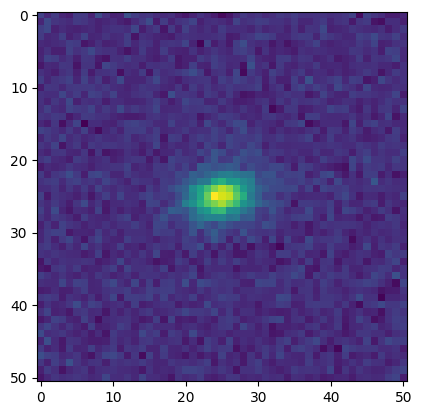

In [5]:
imshow(obs_array)

## Measure galaxy w/ Re-Gaussianisation

In [6]:
obs_shape=galsim.hsm.EstimateShear(
  galsim.Image(obs_array,scale=pixel_scale),
  galsim.Image(psf_array,scale=pixel_scale),
  galsim.Image(weight_array,scale=pixel_scale),
  shear_est='REGAUSS'
)

In [7]:
g1,g2=ngmix.shape.e1e2_to_g1g2(obs_shape.corrected_e1, obs_shape.corrected_e2)

print(f"True:    {intrinsic_shape[0]:.4f}, {intrinsic_shape[1]:.4f}")
print(f"ReGauss: {g1:.4f}, {g2:.4f}")

True:    0.3000, -0.1000
ReGauss: 0.3132, -0.1165


## Metacal

Find centers

In [8]:
obs_cen = (array(obs_array.shape))//2
psf_cen = (array(psf_array.shape))//2

WARNING! Create the correct jacobian from your WCS!

In [9]:
jacobian = ngmix.DiagonalJacobian(
    row=obs_cen[0], col=obs_cen[1], scale=pixel_scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
    row=psf_cen[0], col=psf_cen[1], scale=pixel_scale,
)

Get weight image from pixel variance

In [10]:
wt = obs_array*0 + 1.0/noise_level**2
psf_wt = psf_array*0 + 1.0/(noise_level/10)**2

Make observations

In [11]:
psf_obs = ngmix.Observation(
    psf_array,
    weight=psf_wt,
    jacobian=psf_jacobian,
)

obs = ngmix.Observation(
    obs_array,
    weight=wt,
    jacobian=jacobian,
    psf=psf_obs,
)

We will run NGMIX to create the sheared stamps, but since we want to use HSM, we will get the sheared stamps from the resulting obsdict.

In [12]:
rng = numpy.random.RandomState()
obsdict  = ngmix.metacal.get_all_metacal(obs,psf='dilate',rng=rng)

In [13]:
resdict = {x:None for x in obsdict.keys()}
for key in obsdict.keys():
  obs_img = galsim.Image(obsdict[key].image,scale=pixel_scale)
  psf_img = galsim.Image(obsdict[key].psf.image,scale=pixel_scale)
  
  shape = galsim.hsm.EstimateShear(
    obs_img,
    psf_img,
    galsim.Image(weight_array,scale=pixel_scale),
    shear_est='REGAUSS'  
  )
  e1, e2 = shape.corrected_e1,shape.corrected_e2
   
  resdict.update({key: {'e':[e1,e2]}})
  

Get shear responses

In [14]:
def get_metacal_response_ngmix(resdict,shear_type = 'e'):
  '''gets the shear response for ngmix results'''
  step=0.01
 
  #noshear
  g0s = np.array(resdict['noshear'][shear_type])
  
  #shear
  g1p = np.array(resdict['1p'][shear_type])
  g1m = np.array(resdict['1m'][shear_type])
  g2p = np.array(resdict['2p'][shear_type])
  g2m = np.array(resdict['2m'][shear_type])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R

In [15]:
ellip_dict, R = get_metacal_response_ngmix(resdict)

In [16]:
e = ellip_dict['noshear'] @ np.linalg.inv(R) 

In [17]:
g = ngmix.shape.e1e2_to_g1g2(e[0],e[1])

In [18]:
print(f"True:                   {intrinsic_shape[0]:.4f}, {intrinsic_shape[1]:.4f}")
print(f"ReGauss:                {g1:.4f}, {g2:.4f}")
print(f"Metacalibrated ReGauss: {g[0]:.4f}, {g[1]:.4f}")

True:                   0.3000, -0.1000
ReGauss:                0.3132, -0.1165
Metacalibrated ReGauss: 0.3169, -0.1133
